In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Convolution2D
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import h5py
from sklearn import preprocessing


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fer2013.csv')

In [3]:
df_small = df.head(5)
df_small

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.shape


(35887, 3)

In [5]:
labels = df.values[:, 0]
labels.shape

(35887,)

In [6]:
pix_values = df.values[:, 1]
pixels = np.zeros((df.shape[0], 48*48))
for i in range(len(pix_values)):
  pix_list = pix_values[i].split(" ")

  for j in range(len(pix_list)):
    pixels[i][j] = pix_list[j]

pixels
  

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]])

In [7]:
new_df = pd.concat([df, pd.DataFrame(pixels)], axis=1)
new_df

,emotion,pixels,Usage,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,70.0,80.0,82.0,72.0,58.0,58.0,60.0,63.0,54.0,58.0,60.0,48.0,89.0,115.0,121.0,119.0,115.0,110.0,98.0,91.0,84.0,84.0,90.0,99.0,110.0,126.0,143.0,153.0,158.0,171.0,169.0,172.0,169.0,165.0,129.0,110.0,113.0,...,20.0,31.0,40.0,46.0,65.0,88.0,108.0,110.0,125.0,149.0,157.0,153.0,162.0,164.0,158.0,159.0,154.0,140.0,78.0,21.0,11.0,61.0,144.0,168.0,173.0,157.0,138.0,150.0,148.0,132.0,159.0,182.0,183.0,136.0,106.0,116.0,95.0,106.0,109.0,82.0
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,151.0,150.0,147.0,155.0,148.0,133.0,111.0,140.0,170.0,174.0,182.0,154.0,153.0,164.0,173.0,178.0,185.0,185.0,189.0,187.0,186.0,193.0,194.0,185.0,183.0,186.0,180.0,173.0,166.0,161.0,147.0,133.0,172.0,151.0,114.0,161.0,161.0,...,150.0,129.0,143.0,135.0,115.0,102.0,111.0,124.0,112.0,109.0,132.0,146.0,135.0,149.0,148.0,143.0,163.0,156.0,159.0,150.0,139.0,128.0,116.0,125.0,133.0,109.0,130.0,147.0,130.0,121.0,105.0,108.0,95.0,108.0,102.0,67.0,171.0,193.0,183.0,184.0
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,231.0,212.0,156.0,164.0,174.0,138.0,161.0,173.0,182.0,200.0,106.0,38.0,39.0,74.0,138.0,161.0,164.0,179.0,190.0,201.0,210.0,216.0,220.0,224.0,222.0,218.0,216.0,213.0,217.0,220.0,220.0,218.0,217.0,212.0,174.0,160.0,162.0,...,225.0,220.0,215.0,207.0,199.0,167.0,108.0,151.0,122.0,88.0,71.0,84.0,120.0,127.0,105.0,76.0,71.0,78.0,90.0,106.0,123.0,146.0,155.0,148.0,130.0,141.0,119.0,69.0,54.0,89.0,104.0,138.0,152.0,122.0,114.0,101.0,97.0,88.0,110.0,152.0
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,24.0,32.0,36.0,30.0,32.0,23.0,19.0,20.0,30.0,41.0,21.0,22.0,32.0,34.0,21.0,19.0,43.0,52.0,13.0,26.0,40.0,59.0,65.0,12.0,20.0,63.0,99.0,98.0,98.0,111.0,75.0,62.0,41.0,73.0,118.0,140.0,192.0,...,124.0,150.0,161.0,167.0,169.0,167.0,162.0,164.0,169.0,181.0,172.0,168.0,169.0,170.0,174.0,179.0,180.0,182.0,196.0,208.0,226.0,230.0,140.0,113.0,114.0,125.0,135.0,141.0,172.0,214.0,174.0,126.0,132.0,132.0,133.0,136.0,139.0,142.0,143.0,142.0
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,15.0,23.0,28.0,48.0,50.0,58.0,84.0,115.0,127.0,137.0,142.0,151.0,156.0,155.0,149.0,153.0,152.0,157.0,160.0,162.0,159.0,145.0,121.0,83.0,...,18.0,27.0,19.0,13.0,11.0,22.0,37.0,48.0,55.0,67.0,88.0,95.0,112.0,118.0,123.0,141.0,157.0,174.0,181.0,185.0,184.0,179.0,176.0,171.0,155.0,128.0,105.0,10.0,0.0,0.0,12.0,34.0,31.0,31.0,31.0,27.0,31.0,30.0,29.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest,50.0,36.0,17.0,22.0,23.0,29.0,33.0,39.0,34.0,37.0,37.0,37.0,39.0,43.0,48.0,50.0,53.0,60.0,67.0,69.0,72.0,73.0,82.0,86.0,87.0,94.0,94.0,89.0,84.0,78.0,78.0,80.0,73.0,68.0,63.0,59.0,56.0,...,31.0,29.0,29.0,26.0,24.0,25.0,28.0,33.0,36.0,37.0,42.0,43.0,45.0,45.0,50.0,46.0,52.0,53.0,47.0,41.0,35.0,38.0,50.0,59.0,66.0,68.0,74.0,62.0,110.0,217.0,216.0,215.0,216.0,217.0,221.0,222.0,220.0,223.0,221.0,216.0
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest,178.0,174.0,172.0,173.0,181.0,188.0,191.0,194.0,196.0,199.0,200.0,201.0,204.0,206.0,202.0,195.0,185.0,182.0,183.0,184.0,188.0,191.0,194.0,192.0,187.0,182.0,182.0,184.0,187.0,189.0,190.0,187.0,184.0,180.0,172.0,167.0,164.0,...,133.0,135.0,157.0,171.0,188.0,186.0,177.0,177.0,168.0,157.0,155.0,144.0,126

In [8]:
new_df = new_df.drop("pixels", axis=1)
new_df

,emotion,Usage,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0,Training,70.0,80.0,82.0,72.0,58.0,58.0,60.0,63.0,54.0,58.0,60.0,48.0,89.0,115.0,121.0,119.0,115.0,110.0,98.0,91.0,84.0,84.0,90.0,99.0,110.0,126.0,143.0,153.0,158.0,171.0,169.0,172.0,169.0,165.0,129.0,110.0,113.0,107.0,...,20.0,31.0,40.0,46.0,65.0,88.0,108.0,110.0,125.0,149.0,157.0,153.0,162.0,164.0,158.0,159.0,154.0,140.0,78.0,21.0,11.0,61.0,144.0,168.0,173.0,157.0,138.0,150.0,148.0,132.0,159.0,182.0,183.0,136.0,106.0,116.0,95.0,106.0,109.0,82.0
1,0,Training,151.0,150.0,147.0,155.0,148.0,133.0,111.0,140.0,170.0,174.0,182.0,154.0,153.0,164.0,173.0,178.0,185.0,185.0,189.0,187.0,186.0,193.0,194.0,185.0,183.0,186.0,180.0,173.0,166.0,161.0,147.0,133.0,172.0,151.0,114.0,161.0,161.0,146.0,...,150.0,129.0,143.0,135.0,115.0,102.0,111.0,124.0,112.0,109.0,132.0,146.0,135.0,149.0,148.0,143.0,163.0,156.0,159.0,150.0,139.0,128.0,116.0,125.0,133.0,109.0,130.0,147.0,130.0,121.0,105.0,108.0,95.0,108.0,102.0,67.0,171.0,193.0,183.0,184.0
2,2,Training,231.0,212.0,156.0,164.0,174.0,138.0,161.0,173.0,182.0,200.0,106.0,38.0,39.0,74.0,138.0,161.0,164.0,179.0,190.0,201.0,210.0,216.0,220.0,224.0,222.0,218.0,216.0,213.0,217.0,220.0,220.0,218.0,217.0,212.0,174.0,160.0,162.0,160.0,...,225.0,220.0,215.0,207.0,199.0,167.0,108.0,151.0,122.0,88.0,71.0,84.0,120.0,127.0,105.0,76.0,71.0,78.0,90.0,106.0,123.0,146.0,155.0,148.0,130.0,141.0,119.0,69.0,54.0,89.0,104.0,138.0,152.0,122.0,114.0,101.0,97.0,88.0,110.0,152.0
3,4,Training,24.0,32.0,36.0,30.0,32.0,23.0,19.0,20.0,30.0,41.0,21.0,22.0,32.0,34.0,21.0,19.0,43.0,52.0,13.0,26.0,40.0,59.0,65.0,12.0,20.0,63.0,99.0,98.0,98.0,111.0,75.0,62.0,41.0,73.0,118.0,140.0,192.0,186.0,...,124.0,150.0,161.0,167.0,169.0,167.0,162.0,164.0,169.0,181.0,172.0,168.0,169.0,170.0,174.0,179.0,180.0,182.0,196.0,208.0,226.0,230.0,140.0,113.0,114.0,125.0,135.0,141.0,172.0,214.0,174.0,126.0,132.0,132.0,133.0,136.0,139.0,142.0,143.0,142.0
4,6,Training,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,15.0,23.0,28.0,48.0,50.0,58.0,84.0,115.0,127.0,137.0,142.0,151.0,156.0,155.0,149.0,153.0,152.0,157.0,160.0,162.0,159.0,145.0,121.0,83.0,58.0,...,18.0,27.0,19.0,13.0,11.0,22.0,37.0,48.0,55.0,67.0,88.0,95.0,112.0,118.0,123.0,141.0,157.0,174.0,181.0,185.0,184.0,179.0,176.0,171.0,155.0,128.0,105.0,10.0,0.0,0.0,12.0,34.0,31.0,31.0,31.0,27.0,31.0,30.0,29.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35882,6,PrivateTest,50.0,36.0,17.0,22.0,23.0,29.0,33.0,39.0,34.0,37.0,37.0,37.0,39.0,43.0,48.0,50.0,53.0,60.0,67.0,69.0,72.0,73.0,82.0,86.0,87.0,94.0,94.0,89.0,84.0,78.0,78.0,80.0,73.0,68.0,63.0,59.0,56.0,56.0,...,31.0,29.0,29.0,26.0,24.0,25.0,28.0,33.0,36.0,37.0,42.0,43.0,45.0,45.0,50.0,46.0,52.0,53.0,47.0,41.0,35.0,38.0,50.0,59.0,66.0,68.0,74.0,62.0,110.0,217.0,216.0,215.0,216.0,217.0,221.0,222.0,220.0,223.0,221.0,216.0
35883,3,PrivateTest,178.0,174.0,172.0,173.0,181.0,188.0,191.0,194.0,196.0,199.0,200.0,201.0,204.0,206.0,202.0,195.0,185.0,182.0,183.0,184.0,188.0,191.0,194.0,192.0,187.0,182.0,182.0,184.0,187.0,189.0,190.0,187.0,184.0,180.0,172.0,167.0,164.0,162.0,...,133.0,135.0,157.0,171.0,188.0,186.0,177.0,177.0,168.0,157.0,155.0,144.0,126.0,117.0,111.0,128.0,157.0,163.0,163.0,160.0,158.0,165.0,169.0,175.0,178.0,176.0,173.0,170.0,166.0,155.0,147.0,141.0,136.0,118.0,66.0,7.0,0.0,0.0,0.0,0.0
35884,0,PrivateTest,17.0,17.0,16.0,23.0,28.0,22.0,19.0,17.0,25.0,26.0,20.0,24.0,31.0,19.0,27.0,92.0,164.0,195.0,220.0,150.0,123.0,190.0,168.0,86.0,82.0,134.0,18

In [9]:
training_set = new_df[new_df["Usage"] == "Training"]
test_set = new_df[new_df["Usage"] == "PublicTest"]
train_x = training_set.drop(["Usage","emotion"], axis=1)
test_x = test_set.drop(["Usage","emotion"], axis=1)

train_y = training_set["emotion"]
test_y = test_set["emotion"]



train_y=np_utils.to_categorical(train_y, num_classes=7)  
test_y=np_utils.to_categorical(test_y, num_classes=7)


train_x = preprocessing.scale(train_x)
test_x = preprocessing.scale(test_x)


train_x = train_x.reshape((train_x.shape[0], 48, 48, 1 ))
test_x = test_x.reshape((test_x.shape[0], 48, 48, 1))



print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(28709, 48, 48, 1)
(28709, 7)
(3589, 48, 48, 1)
(3589, 7)


MODEL TRAINING

In [38]:
batch_size = 64
epochs = 150
patience = 15

In [39]:

def model_creation(first_filter, second_filter, third_filter):

  model = Sequential()  
    
  model.add(Conv2D(first_filter, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))  
  model.add(Conv2D(first_filter,kernel_size= (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))  
  model.add(Dropout(0.5))  

  model.add(Conv2D(second_filter, kernel_size = (3, 3), activation='relu'))  
  model.add(Conv2D(second_filter, kernel_size = (3, 3), activation='relu'))   
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))  
  model.add(Dropout(0.5))  


  model.add(Conv2D(third_filter, kernel_size = (3, 3), activation='relu'))  
  model.add(Conv2D(third_filter, kernel_size = (3, 3), activation='relu'))   
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2),padding='same'))  
  model.add(Dropout(0.5)) 
  
   


  model.add(Flatten())  
    
  model.add(Dense(1024, activation='relu'))  
  model.add(Dropout(0.2))  
  model.add(Dense(64, activation='relu'))  
  model.add(Dropout(0.2))  
    
  model.add(Dense(7, activation='softmax'))  

  model.summary()

  return model

In [40]:

def model_fit(model):

  model.compile(loss="categorical_crossentropy",  
                optimizer="adam",  
                metrics=['accuracy'])  

  es = EarlyStopping(monitor='val_loss', mode='min', patience = patience, verbose=1)
    
  model_res = model.fit(train_x, train_y,  
            batch_size=batch_size,  
            epochs=epochs, 
            shuffle=True,   
            validation_data=(test_x, test_y),
            callbacks = [es]) 
  
  return model_res
  

In [41]:

model = model_creation(32,64,64)
                         
model_res = model_fit(model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 9, 64)         

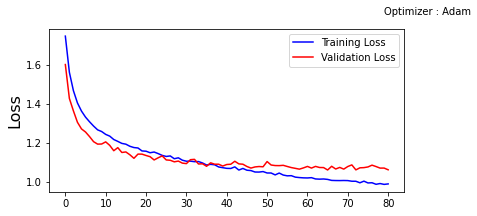

In [42]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_res.history['loss'], 'b', label='Training Loss')
plt.plot(model_res.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

In [44]:
model.evaluate(test_x,test_y)

113/113 [==============================] - 0s 4ms/step - loss: 1.0640 - accuracy: 0.6091


[1.0639867782592773, 0.6090832948684692]

In [33]:
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save_weights("fer.h5")
